# 0. Imports, configs y checks

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # un poco menos de warnings de tensorflow
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # deshabilitar la dGPU

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
#import plotly.express as px

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

# pandas para el csv
import pandas as pd

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [ ]:
# Ver si detecta la GPU en caso de haberla
gpus = tf.config.list_physical_devices("GPU")

if gpus:
 for gpu in gpus:
    print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

# 1. Análisis exploratorio sobre el conjunto de datos

In [ ]:
# lo vamos a estar usando seguido
CATEGORIES = 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./train')
TEST_DIR = Path('./test')
VALIDATION_DIR = Path('./validation')
SIZE = 150

Creamos datasets para Keras:

In [ ]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CATEGORIES,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [ ]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

## Volumetría de los datos

El dataset de train y test cuenta con imágenes de escenas naturales de todo el mundo, train contiene 14034 imágenes y el dataset de test cuenta con 3000 imágenes, dando un total de 258 MB train y test juntos.
Las imagenes se dividiran en 6 categorias:

* "buildings": imagenes de edificios
* "forest": imagenes de bosques en diferentes estaciones y ambientes
* "glacier": imagenes de paisajes nevados
* "mountain": imagenes de montañas en distintos ambientes
* "sea": imagenes sobre oceanos y playas
* "street": imagenes de paisaje urbano

In [ ]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CATEGORIES[np.argmax(labels[i])])
        plt.axis("off")

In [ ]:
sample_images(train)

Luego de revisar brevemente las carpetas, observamos que existen varias imagenes que difieren de las categorias, y decidimos eliminarlas del dataset de train, puesto que estas imagenes pueden tener un impacto negativo a la hora de entrenar

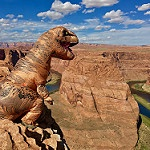

In [4]:
#mostrar imagen del dino
tf.keras.utils.load_img("./train/glacier/1512.jpg")

aaah yes... a glacier...

Por ultimo, decidimos dividir la carpeta de train para crear una carpeta de validation, mediante el uso de un script externo "trainValidationSplit.sh"

In [ ]:
sample_images(validation)

## Estructura y tipo de las imágenes

Las imagenes:
* tienen una dimension de 150x150
* todas son del tipo "jpg"

## Distribución de la variable a predecir

Primero contamos con una carpeta "train" que contiene carpetas por cada  categoria de imagen

In [ ]:
root_path = "./train"

contents = os.listdir(root_path)

# Loop through each item in the list
for item in contents:
    # Check if the item is a directory
    if os.path.isdir(os.path.join(root_path, item)):
        print("Found directory:", item)

Vemos la cantidad de imagenes que existe en la carpeta train

In [ ]:
num_images = 0
for dirpath, dirnames, filenames in os.walk(root_path):
    # Count the number of image files in the current subdirectory
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            num_images += 1

    # Print the number of image files in the current subdirectory
    print(f"Found {num_images} images in directory: {dirpath}")
    num_images = 0

In [ ]:
subdirectories = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(subdirectories, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

Podemos ver que existe un balance entre clases, con poca diferencia entre las mismas, lo que favorece al entrenamiento.

# 2. Modelado

### Funciones y variables

In [ ]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)

In [ ]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [ ]:
datasets = (
    ('train', images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS, batch_size=-1)),
    ('validation', images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS, batch_size=-1)),
)

def show_confusion_matrix(model):
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)
    
        batch_images, batch_labels = next(dataset)
        
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        predictions = np.argmax(model.predict(batch_images), axis=-1)
        labels = np.argmax(batch_labels, axis=-1)
        
        print('Accuracy:', accuracy_score(labels, predictions))
    
        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))
            
        plt.xticks([0, 1, 2, 3, 4, 5], CATEGORIES, rotation=45)
        plt.yticks([0, 1, 2, 3, 4, 5], CATEGORIES)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')
    
        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )
    
        plt.show()

In [ ]:
def compile_summarize(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy',],
    )
    model.summary()

In [ ]:
def accuracy_over_epochs(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
def fit_model(model, n_epochs=5):
    return model.fit(
        train,
        epochs=n_epochs,
        batch_size=128,
        validation_data=validation,
        callbacks=[OurCustomCallback()]
    )

In [ ]:
# no parecería andar
# gc.collect() y del (modelo) tampoco
# con suerte la env var de la primer celda hace algo por el lado de CUDA
# https://github.com/tensorflow/tensorflow/issues/36465
def clear_vram():
    tf.keras.backend.clear_session(free_memory=True)

### Entrenamientos

#### MLP Simple

In [ ]:
# MLP simple
clear_vram()
model_mlp = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [ ]:
compile_summarize(model_mlp)

In [ ]:
history_mlp = fit_model(model_mlp)

In [ ]:
accuracy_over_epochs(history_mlp)

In [ ]:
model_mlp.set_weights(model_weights_at_epochs[4])

In [ ]:
show_confusion_matrix(model_mlp)

#### Convolucional

In [ ]:
# Convolucional
clear_vram()
model_convolutional = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [ ]:
compile_summarize(model_convolutional)

In [ ]:
history_convolutional = fit_model(model_convolutional)

In [ ]:
accuracy_over_epochs(history_convolutional)

In [ ]:
model_convolutional.set_weights(model_weights_at_epochs[4])

In [ ]:
show_confusion_matrix(model_convolutional)

#### Convolucional VGG16

In [ ]:
# Convolucional usando convoluciones ya entrenadas de VGG16
clear_vram()
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_vgg16 = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(CATEGORIES), activation='softmax'),
])

In [ ]:
compile_summarize(model_vgg16)

In [ ]:
history_vgg16 = fit_model(model_vgg16)

In [ ]:
accuracy_over_epochs(history_vgg16)

In [ ]:
model_vgg16.set_weights(model_weights_at_epochs[1])

In [ ]:
show_confusion_matrix(model_vgg16)

# 3. Conclusiones

# 4. Competencia

Creación de archivos CSV para la submission

In [ ]:
CSV_FILENAME = "ConvolutionalDefault"
MODEL = model

images = []
labels = []

for image in os.listdir(TEST_DIR):
    image_path = os.path.join(TEST_DIR, image)
    image_array = img_to_array(load_img(image_path, target_size=(SIZE, SIZE)))
    images.append(image_array)

inputs = np.array(images) / 255.0

predictions = MODEL.predict(inputs)

for i, filename in enumerate(os.listdir(TEST_DIR)):
    predicted_label = CATEGORIES[np.argmax(predictions[i])]
    labels.append([filename, predicted_label])

df = pd.DataFrame(labels, columns=["ID", "Label"])
df.to_csv(CSV_FILENAME+".csv", index=False)